## Coding Challenge for Fracta

成田博行　2022年6月12日　

### Task 1 を選択 

- 2021年におけるパイプの故障率を予測するモデルを構築する
- モデルの評価指標を作成し、それに基づいてモデルを評価する

lightGBMとXGBoostでモデルを作成した。

- 2021年における故障率
    * モデルA: 2.5%
    * モデルB: 2.8%

- 作成した評価指標
    * モデルA: 6.3%
    * モデルB: 5.8%

作成した評価指標を比較するとモデルBの方が信頼性が高く、その場合2021年における故障率は2.8%になりました。

In [11]:
!pip3 install Japanize-matplotlib

In [12]:
import pandas as pd
import numpy as np
import joblib
import sys, os
import dateutil
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
sys.path.append('../..')
from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df_pipe = pd.read_csv('./fracta_Dec3.csv')
df_wk = df_pipe.copy()
display(df_wk.head())

,pipe_id,install_year,material,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,...,env_dat_135,env_dat_136,env_dat_137,env_dat_138,env_dat_139,env_dat_140,env_dat_141,env_dat_142,env_dat_143,env_dat_144
0,P0000000000,1985,D,20.32,NaN,623.542175,18.052843,14.161422,10.268579,159.662827,...,554.479675,20.000000,0.000038,438.628143,27.000000,3085.786865,0.002728,0.311803,0.0,0.0
1,P0000000001,1934,C,15.24,NaN,644.830017,17.790001,13.830000,9.870000,257.001221,...,276.357605,9.200573,0.304329,239.719299,32.571018,3188.292236,0.003291,0.322161,0.0,0.0
2,P0000000002,1904,C,20.32,NaN,604.570007,18.219999,14.350000,10.470000,225.165039,...,236.882950,4.872639,0.182168,500.638367,28.978306,4542.257324,0.002928,0.458972,0.0,0.0
3,P0000000003,1979,D,15.24,NaN,573.424011,17.671381,14.132636,10.586646,170.244339,...,321.886658,12.353504,0.480517,295.554504,41.983772,4521.720215,0.004242,0.456897,0.0,0.0
4,P0000000004,1987,D,20.32,NaN,583.429993,18.280001,14.350000,10.420000,171.034073,...,758.841431,25.052542,0.021532,778.687256,25.842377,4978.718262,0.002611,0.503074,0.0,0.0


- 全体で56774件のレコードが存在し、そのうち故障件数は3144
- およそ5.5%程に故障年が存在する

In [14]:
total = len(df_wk)
death = len(df_wk['break_year'].notna())
birth = len(df_wk['install_year'].notna())

display(total)
display(death)
display(death/total)

56774

56774

1.0

In [15]:
df_wk = pd.get_dummies(df_wk, columns=['material'])

In [16]:
# df_wk['pipe_id_int']=df_wk['pipe_id'].apply(lambda x: x[1:] if x[0] == 'P' else None).astype(int)

故障したものについて年数を算出する

3144

<AxesSubplot:>

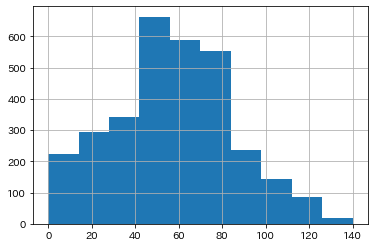

In [17]:
df_break=df_wk[df_wk['break_year'].notna()].copy()
# df_break['break_year'].hist()

df_break['age'] = df_break['break_year'] - df_break['install_year']
display(len(df_break))
df_break['age'].hist()

パイプの年齢の平均を可視化

1980年から傾向に変化が見える

<AxesSubplot:>

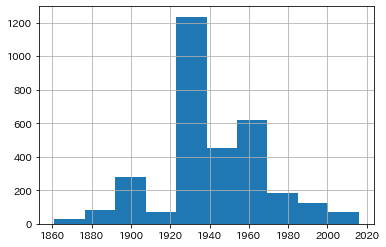

In [18]:
df_break['install_year'].hist()

1980年以降に破損データの採取が始められたと思われる。

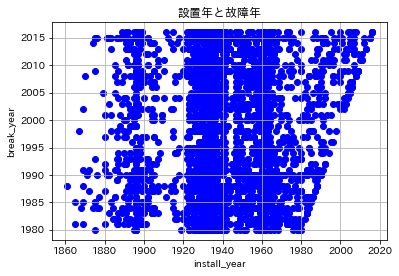

In [19]:
plt.scatter(df_break['install_year'], df_break['break_year'], color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
# plt.plot(df_break['install_year'], df_break['break_year'], color = 'red') # 回帰直線をプロット

plt.title('設置年と故障年')
plt.xlabel('install_year')
plt.ylabel('break_year')
plt.grid()

plt.show()   

1861年から2017年のデータが存在します。

In [20]:
df_break[df_break['install_year'] > 1980].count()

pipe_id         238
install_year    238
diameter        236
break_year      238
env_dat_0       238
               ... 
material_C      238
material_D      238
material_O      238
material_S      238
age             238
Length: 155, dtype: int64

パイプの設置年毎にその年齢（故障までの年数）を可視化する

1980年までは設置年と年齢を足すとおよそ1980

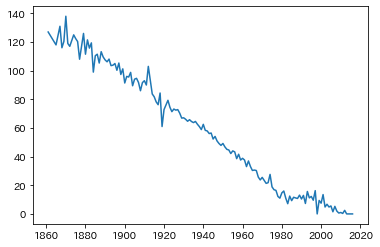

In [21]:
df_stats = df_break.set_index('install_year')
df_stats = df_stats.groupby('install_year').mean()
plt.plot(df_stats['age'])

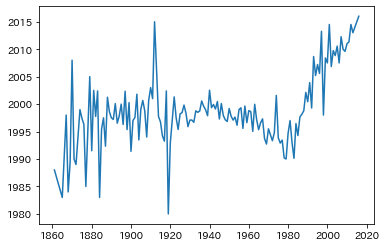

In [22]:
plt.plot(df_stats['break_year'])

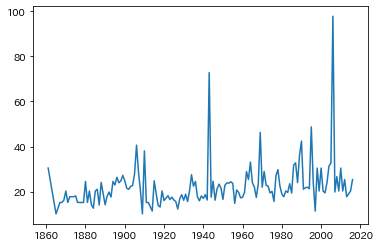

In [23]:
plt.plot(df_stats['diameter'])

正常なものについて年数を算出します。

53630

<AxesSubplot:>

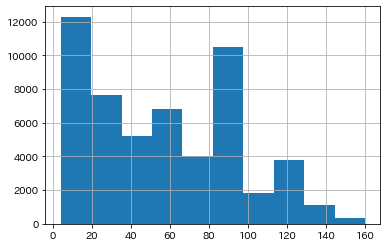

In [24]:
df_alive=df_wk[df_wk['break_year'].isna()]
# df_break['break_year'].hist()

df_alive['age'] = 2021 - df_alive['install_year']
display(len(df_alive))
df_alive['age'].hist()

<AxesSubplot:>

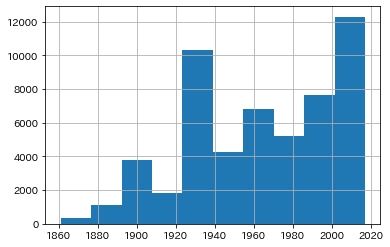

In [25]:
df_alive['install_year'].hist()

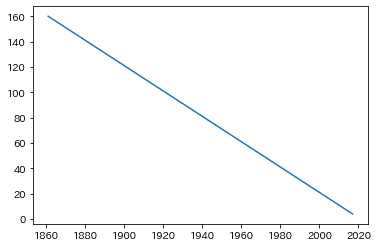

In [26]:
df_stats = df_alive.set_index('install_year')
df_stats = df_stats.groupby('install_year').mean()
plt.plot(df_stats['age'])

故障年は1980年から2016年までです

<AxesSubplot:>

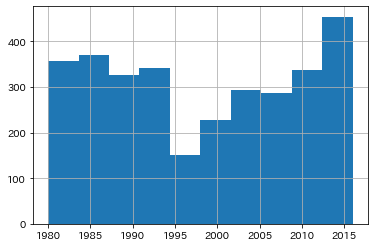

In [27]:
df_break['break_year'].hist()

In [28]:
df_break.head()

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S,age
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,0.000505,0.383964,0.0,0.0,0,0,1,0,0,7.0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,0.001921,0.453269,0.0,1.0,0,0,1,0,0,27.0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,0.002991,0.310529,0.0,0.0,0,0,1,0,0,12.0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,0.002717,0.536662,0.0,0.0,0,1,0,0,0,91.0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,0.002754,0.321194,0.0,0.0,0,1,0,0,0,48.0


In [29]:
df_break.head()

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S,age
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,0.000505,0.383964,0.0,0.0,0,0,1,0,0,7.0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,0.001921,0.453269,0.0,1.0,0,0,1,0,0,27.0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,0.002991,0.310529,0.0,0.0,0,0,1,0,0,12.0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,0.002717,0.536662,0.0,0.0,0,1,0,0,0,91.0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,0.002754,0.321194,0.0,0.0,0,1,0,0,0,48.0


In [30]:
# import math
# def draw_graph(df_product):
#     cols = 5
#     nums = 145
#     rows = math.ceil(nums / cols)
#     fig = plt.figure(facecolor='white', figsize=(10 * cols, 10 * rows))
    
#     # for i, (name, code) in enumerate(zip(df_product['製品名'], df_product['製品コード'])):
#     for i in range(nums):
#         ax = fig.add_subplot(rows, cols, i + 1)
#         label = 'env_dat_'+str(i)
#         df = df_product[label]
#         ax.hist(df)
#         plt.xticks(rotation=90)
#         ax.set_title(f'{label}')
#         ax.set_ylabel(f'{label}')
#         # ax.set_xlabel('受注月')
#     fig.tight_layout()
#     fig.show()
#     fig.savefig(f'{label}.png')

In [31]:
# draw_graph(df_break)

<AxesSubplot:>

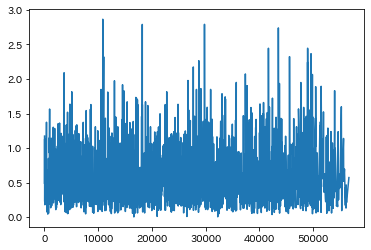

In [32]:
df_break['env_dat_66'].plot()

In [33]:
from sklearn import covariance

In [34]:
df_break

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S,age
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,0.000505,0.383964,0.0,0.0,0,0,1,0,0,7.0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,0.001921,0.453269,0.0,1.0,0,0,1,0,0,27.0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,0.002991,0.310529,0.0,0.0,0,0,1,0,0,12.0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,0.002717,0.536662,0.0,0.0,0,1,0,0,0,91.0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,0.002754,0.321194,0.0,0.0,0,1,0,0,0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56095,P0000054880,1964,15.24,1984.0,562.931030,18.405867,14.575810,10.738604,7.679123,0.000045,...,0.000101,0.014225,1.0,0.0,0,1,0,0,0,20.0
56141,P0000054926,2007,10.16,2010.0,584.570007,18.320000,14.410000,10.500000,29.354458,0.004830,...,0.002143,0.144087,0.0,0.0,0,0,1,0,0,3.0
56155,P0000054940,1896,30.48,2010.0,560.340027,17.889999,14.270000,10.650000,18.379753,0.000995,...,0.001934,0.403976,1.0,0.0,0,1,0,0,0,114.0
56200,P0000054985,2015,20.32,2015.0,644.830017,17.790001,13.830000,9.870000,104.294373,0.009084,...,0.004105,0.351462,0.0,0.0,0,0,1,0,0,0.0


In [35]:
Q = df_break.iloc[:,1:]

In [36]:
# Create correlation matrix
corr_matrix = Q.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
Q.drop(to_drop, axis=1, inplace=True)


In [37]:
Q


,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_4,env_dat_5,env_dat_7,env_dat_8,env_dat_10,...,env_dat_137,env_dat_138,env_dat_139,env_dat_140,env_dat_143,env_dat_144,material_A,material_C,material_O,material_S
41,1983,20.32,1990.0,568.710022,17.559999,0.023671,0.000005,0.000043,0.004607,0.000202,...,64.451736,2302.071777,5.000000,3799.932617,0.0,0.0,0,0,0,0
52,1968,20.32,1995.0,580.960022,18.260000,299.776337,0.037117,0.001423,0.012844,0.005945,...,7.289519,982.682190,19.008602,4485.814941,0.0,1.0,0,0,0,0
63,1991,10.16,2003.0,615.322571,18.112228,105.444649,0.010701,0.000640,0.013378,0.000843,...,0.139931,279.237274,29.602262,3073.178467,0.0,0.0,0,0,0,0
68,1924,20.32,2015.0,610.489990,17.080000,113.146187,0.007912,0.013428,0.007992,0.030000,...,0.448107,848.168884,26.890890,5311.120117,0.0,0.0,0,1,0,0
87,1947,15.24,1995.0,644.830017,17.790001,86.456589,0.006315,0.001049,0.025310,0.000962,...,6.623856,366.002197,27.252457,3178.726807,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56095,1964,15.24,1984.0,562.931030,18.405867,7.679123,0.000045,0.000478,0.000050,0.005968,...,140.774643,140.774643,1.000000,140.774643,1.0,0.0,0,1,0,0
56141,2007,10.16,2010.0,584.570007,18.320000,29.354458,0.004830,0.004265,0.003997,0.012003,...,0.011256,131.765839,21.208111,1425.973389,0.0,0.0,0,0,0,0
56155,1896,30.48,2010.0,560.340027,17.889999,18.379753,0.000995,0.000000,0.000000,0.004293,...,16.337278,1051.843750,19.135569,3997.978271,1.0,0.0,0,1,0,0
56200,2015,20.32,2015.0,644.830017,17.790001,104.294373,0.009084,0.000268,0.022360,0.002161,...,0.727355,246.110458,40.624638,3478.270996,0.0,0.0,0,0,0,0


特徴量エンジニアリング

- age をbreak_year - install_year から生成
- age を追加し、install_year, break_year は消去


In [38]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']
A_install_year = df_alive['install_year']

強い相関のある特徴量を取り除く

In [39]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

In [40]:
drop_list = [
    # 'env_dat_31',
    # 'env_dat_40',
    # 'env_dat_48',
    # 'env_dat_80',
    # 'env_dat_99',
    # 'env_dat_123',
    # 'env_dat_126',
    # 'env_dat_127',
    # 'env_dat_27',
    # 'env_dat_45',
    # 'env_dat_49',
    # 'env_dat_51',
    # 'env_dat_77',    
    # 'env_dat_78',
    # 'env_dat_124',
    # 'env_dat_36',
    # 'env_dat_130', 
    # 'env_dat_55',
    # 'env_dat_118',
    # 'env_dat_35',
    # 'env_dat_76',
    # 'env_dat_28',
    # 'env_dat_52',
    # 'env_dat_56',
    # 'env_dat_125',
    # 'env_dat_75',
    # 'env_dat_79',
    # 'env_dat_128',
    # 'env_dat_46',
    # 'env_dat_37', 
    # 'env_dat_44', 
    # 'env_dat_58', 
    # 'env_dat_33', 
    # 'env_dat_43', 
    # 'env_dat_47', 
    # 'env_dat_50', 
    # 'env_dat_96', 
    # 'env_dat_84', 
    # 'env_dat_17', 
    # 'env_dat_90', 
    # 'env_dat_30', 
    # 'env_dat_83', 
    # 'env_dat_42', 
    # 'env_dat_53', 
    # 'env_dat_117', 
    # 'env_dat_91', 
    # 'env_dat_143', 
    # 'env_dat_85', 
    # 'env_dat_81', 
    # 'env_dat_100',  
    # 'env_dat_100',    
    'age', 
    'pipe_id',
    'break_year',
    'install_year',
    ]

X = df_break.drop(drop_list, axis=1)
A = df_alive.drop(drop_list, axis=1)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21019
[LightGBM] [Info] Number of data points in the train set: 2106, number of used features: 136
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Start training from score 56.705128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

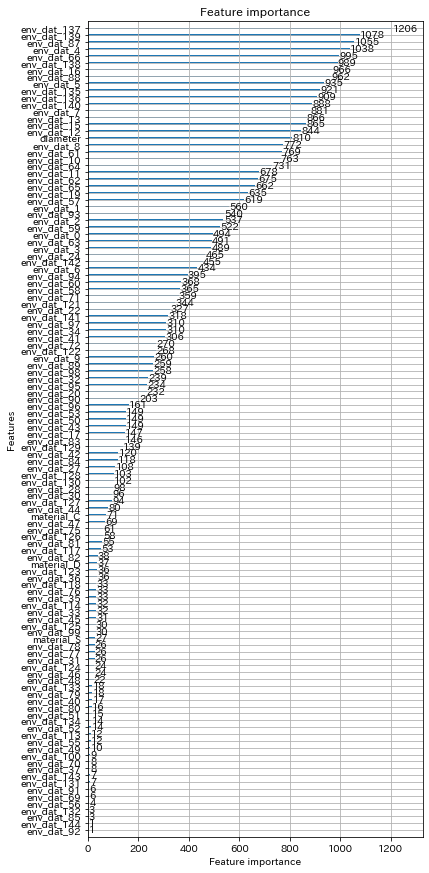

In [42]:
%%time
### optunaつかう
# LightGBM用のデータセットに変換
# import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb_o
from lightgbm import Dataset

train = Dataset(X_train, y_train)
val = Dataset(X_test, y_test)

# train = xgb.DMatrix(X_train, y_train)
# val = xgb.DMatrix(X_test, y_test)

# ハイパーパラメータサーチ&モデル構築
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_seed': 0,
        'feature_pre_filter': False,
        'lambda_l1': 0.01,
        'lambda_l2': 0.04,
        'num_leaves': 500,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 100,
        'min_data_in_leaf': 5,
        'min_child_samples': 5,
        'num_iterations': 1000,
        'early_stopping_round': 3000    
}

gbm_o = lgb_o.train(params,
                    train,
                    valid_sets=val,
                    early_stopping_rounds=3000,
                    verbose_eval=20000)

# gbm_o = xgb.train(params,
#                     train,
#                     # valid_sets=val,
#                     early_stopping_rounds=3000,
#                     verbose_eval=20000)                    

# ベストパラメータの取得


best_params = gbm_o.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

import lightgbm as lgb

## 新たにlightGBMで全trainデータ再学習させる場合 ##
# params_best = dict(best_params.items())

# gbm = lgb.LGBMRegressor(**params_best,random_state=0)

# gbm.fit(train_X, train_y)
# y_pred_train = gbm.predict(train_X, num_iteration=gbm_o.best_iteration)
# y_pred_test = gbm.predict(test_X, num_iteration=gbm_o.best_iteration)
###################################################

## lightGBM-optunaで学習した(train_test_splitでval有)モデルで推論する場合
y_pred_train = gbm_o.predict(X_train, num_iteration=gbm_o.best_iteration)
y_pred_test = gbm_o.predict(X_test, num_iteration=gbm_o.best_iteration)
############################################################################

# # モデルのインスタンスの作成
# model = lgb.LGBMRegressor()


# model.fit(train_X, train_y) # モデルの学習
# y_pred_train = model.predict(train_X)


# テストデータの予測
# y_pred_test = model.predict(test_X)


lgb.plot_importance(gbm_o, figsize=(6, 15))

In [43]:
# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

scores = calculate_scores(y_test, y_pred_test)
display(scores)

,R2,MAE,MSE,RMSE
scores,0.50971,15.222475,390.30281,19.756083


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

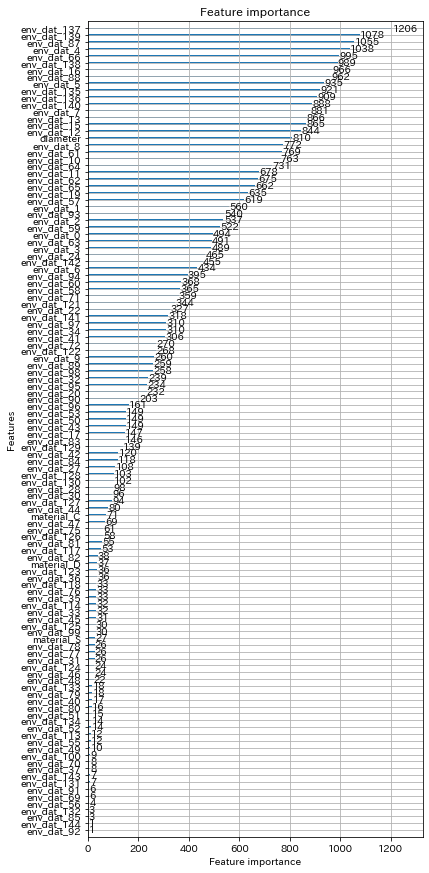

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

lgb.plot_importance(gbm_o, figsize=(6, 15))

In [45]:
y_pred_train = gbm_o.predict(X_train, num_iteration=gbm_o.best_iteration)
y_pred_test = gbm_o.predict(X_test, num_iteration=gbm_o.best_iteration)

2106

(array([128., 143., 238., 386., 512., 384., 161.,  96.,  46.,  12.]),
 array([ -4.00611251,  10.3681384 ,  24.7423893 ,  39.1166402 ,
         53.4908911 ,  67.865142  ,  82.23939291,  96.61364381,
        110.98789471, 125.36214561, 139.73639651]),
 <BarContainer object of 10 artists>)

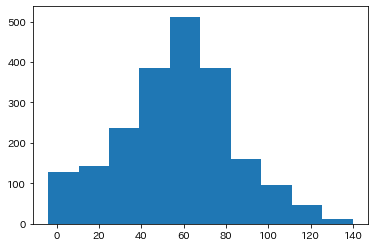

In [46]:
display(len(y_pred_train))
plt.hist(y_pred_train)

<AxesSubplot:>

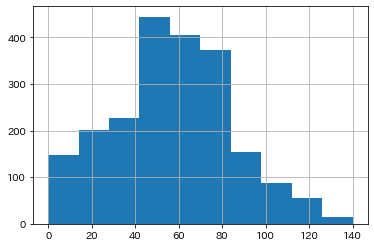

In [47]:
y_train.hist()

1038

(array([ 16.,  84.,  73., 106., 228., 314., 125.,  64.,  17.,  11.]),
 array([ -5.26658431,   7.76475495,  20.79609421,  33.82743346,
         46.85877272,  59.89011198,  72.92145124,  85.95279049,
         98.98412975, 112.01546901, 125.04680826]),
 <BarContainer object of 10 artists>)

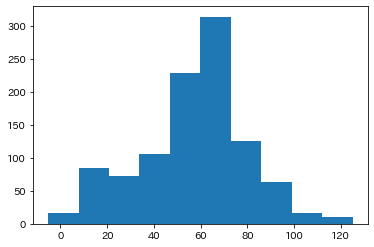

In [48]:
display(len(y_pred_test))
plt.hist(y_pred_test)

<AxesSubplot:>

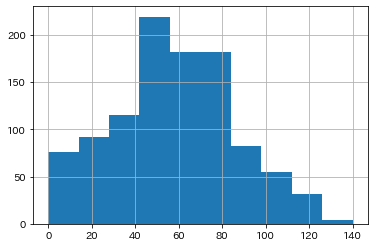

In [49]:
y_test.hist()

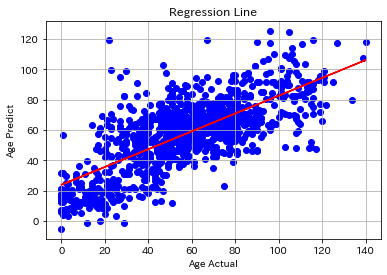

In [50]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

y_list_test = y_test.to_numpy()
lr.fit(y_list_test.reshape(-1, 1), y_pred_test)

plt.scatter(y_list_test, y_pred_test, color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(y_list_test, lr.predict(y_list_test.reshape(-1, 1)), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')
plt.xlabel('Age Actual')
plt.ylabel('Age Predict')
plt.grid()

plt.show()          

### 現在生存するデータ寿命を予測する

In [51]:
A

,diameter,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,env_dat_6,env_dat_7,env_dat_8,...,env_dat_140,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S
0,20.32,623.542175,18.052843,14.161422,10.268579,159.662827,0.010340,0.030000,0.000000,0.014131,...,3085.786865,0.002728,0.311803,0.0,0.0,0,0,1,0,0
1,15.24,644.830017,17.790001,13.830000,9.870000,257.001221,0.007786,0.030000,0.002000,0.020461,...,3188.292236,0.003291,0.322161,0.0,0.0,0,1,0,0,0
2,20.32,604.570007,18.219999,14.350000,10.470000,225.165039,0.014548,0.006675,0.002439,0.019730,...,4542.257324,0.002928,0.458972,0.0,0.0,0,1,0,0,0
3,15.24,573.424011,17.671381,14.132636,10.586646,170.244339,0.014938,0.005481,0.000583,0.013436,...,4521.720215,0.004242,0.456897,0.0,0.0,0,0,1,0,0
4,20.32,583.429993,18.280001,14.350000,10.420000,171.034073,0.025906,0.008322,0.000000,0.013436,...,4978.718262,0.002611,0.503074,0.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56769,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,0.015962,...,2504.886719,0.002627,0.253106,0.0,0.0,0,0,1,0,0
56770,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,0.015962,...,2504.886719,0.002627,0.253106,0.0,0.0,0,0,1,0,0
56771,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,0.015962,...,2504.886719,0.002627,0.253106,0.0,0.0,0,0,1,0,0
56772,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,0.015962,...,2504.886719,0.002627,0.253106,0.0,0.0,0,0,1,0,0


### 年齢を予測します。

In [52]:
pred = gbm_o.predict(A, num_iteration=gbm_o.best_iteration)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

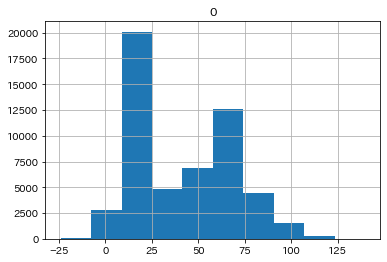

In [53]:
pd.DataFrame(pred).hist()

In [54]:
A['age'] = pd.DataFrame(pred.tolist()).astype(int)
A['install_year'] = A_install_year
A['break_year'] = A['install_year'] + A['age']

予測された破損件数のヒストグラムを見てみます。

<AxesSubplot:>

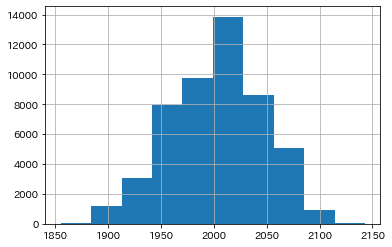

In [55]:
A['break_year'].hist()

<AxesSubplot:>

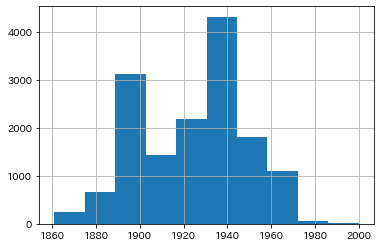

In [56]:
A[A['break_year'] < 1980]['install_year'].hist()

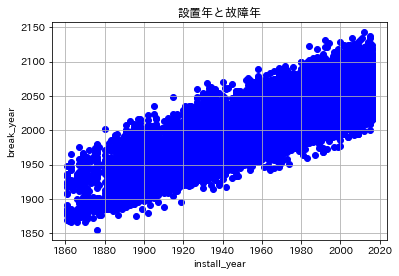

In [57]:
plt.scatter(A['install_year'], A['break_year'], color = 'blue')

plt.title('設置年と故障年')
plt.xlabel('install_year')
plt.ylabel('break_year')
plt.grid()

plt.show()  

### 2021年にパイプが破損する確率を求めたい
- S: 2020年には生きている（正常である）
- D: 2021年に死ぬ（破損する）

S, D が以上で与えられている時、求める確率は以下の通りです。

P(D|S) = P(D)/P(S)

In [58]:
p_s = (len(A) - len(A[A['break_year'] <= 2020])) / len(A) 
display(p_s)

p_d = len(A[A['break_year'] == 2021]) / len(A)
display (p_d)

p_2021 = p_d / p_s

display(p_2021)


0.4007831437628193

0.010124930076449748

0.02526286405508514

2021年にパイプが破損する確率は約2.5％の予測になります。

予測において故障年は設置年よりも後に来る必要があります

あるいは、パイプの年齢が負である事はありえません

そうでない予測は誤りですから、それらの全予測における割合を測ります

In [59]:
def my_metric(A):
    return 1 - len(A[A['age'] >= 0]) / len(A)

display(my_metric(A))

0.0634532910684319

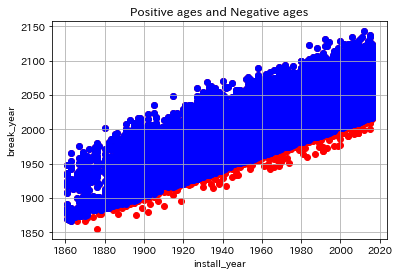

In [60]:
df_pos = A[A['break_year'] > A['install_year']] 

plt.scatter(A['install_year'], A['break_year'], color = 'red')
plt.scatter(df_pos['install_year'], df_pos['break_year'], color = 'blue')

plt.title('Positive ages and Negative ages')
plt.xlabel('install_year')
plt.ylabel('break_year')
plt.grid()

plt.show()  

In [61]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

In [62]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']
A_install_year = df_alive['install_year']

drop_list = [
    # 'env_dat_31',
    # 'env_dat_40',
    # 'env_dat_48',
    # 'env_dat_80',
    # 'env_dat_99',
    # 'env_dat_123',
    # 'env_dat_126',
    # 'env_dat_127',
    # 'env_dat_27',
    # 'env_dat_45',
    # 'env_dat_49',
    # 'env_dat_51',
    # 'env_dat_77',    
    # 'env_dat_78',
    # 'env_dat_124',
    # 'env_dat_36',
    # 'env_dat_130', 
    # 'env_dat_55',
    # 'env_dat_118',
    # 'env_dat_35',
    # 'env_dat_76',
    # 'env_dat_28',
    # 'env_dat_52',
    # 'env_dat_56',
    # 'env_dat_125',
    # 'env_dat_75',
    # 'env_dat_79',
    # 'env_dat_128',
    # 'env_dat_46',
    # 'env_dat_37', 
    # 'env_dat_44', 
    # 'env_dat_58', 
    # 'env_dat_33', 
    # 'env_dat_43', 
    # 'env_dat_47', 
    # 'env_dat_50', 
    # 'env_dat_96', 
    # 'env_dat_84', 
    # 'env_dat_17', 
    # 'env_dat_90', 
    # 'env_dat_30', 
    # 'env_dat_83', 
    # 'env_dat_42', 
    # 'env_dat_53', 
    # 'env_dat_117', 
    # 'env_dat_91', 
    # 'env_dat_143', 
    # 'env_dat_85', 
    # 'env_dat_81', 
    # 'env_dat_100',  
    # 'env_dat_100',    
    'age', 
    'pipe_id',
    'break_year',
    'install_year',
    ]

X = df_break.drop(drop_list, axis=1)
A = df_alive.drop(drop_list, axis=1)

In [63]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

optuna = False
if optuna:
    def objective(trial):
        # データを訓練用と検証用に分割する
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.33, random_state=42)

        # 1. パラメータと値の設定
        # 最適化したいパラメータと，パラメータがとる値の範囲を指定する
        params = {
            # "silent": 1,
            "max_depth": trial.suggest_int("max_depth", 3, 300),
            "min_child_weight": 1,
            "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
            "tree_method": "exact",
            # "objective": "reg:linear",
            "eval_metric": "rmse",
            "predictor": "cpu_predictor",  
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_leaves": trial.suggest_int("max_leaves", 1, 300),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        }

        # 2. モデルの訓練と評価
        # モデルの訓練
        model = xgb.XGBRegressor(**params)
        model.fit(train_X, train_y)

        # モデルの評価
        pred = model.predict(val_X)
        score = mean_squared_error(val_y, pred, squared=False)

        # 3. 目的関数の値を返す
        # 今回は回帰問題のためRMSEの値を最小化することを目的とする
        return score

    study = optuna.create_study(direction="minimize") 
    study.optimize(objective, 1, timeout=600)

    best_params = study.best_params
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [64]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

In [65]:
best_params = {
    # "silent": 1,
    # "n_estimators": 360,
    "max_depth": 7,
    "max_leaves":20,
    "learning_rate":0.015, 
    "min_child_weight": 1,
    "eta": 0.1,
    "tree_method": "exact",
    # "objective": "reg:linear",
    "eval_metric": "rmse",
    "predictor": "cpu_predictor"
}

model = xgb.train(params=best_params,
                  dtrain=dtrain,
                  num_boost_round=3000,
                  early_stopping_rounds=30,
                  evals= [(dtrain, "train"), (dvalid, "valid")]
)

[0]	train-rmse:61.89195	valid-rmse:62.60408
[1]	train-rmse:61.04997	valid-rmse:61.78124
[2]	train-rmse:60.22271	valid-rmse:60.96770
[3]	train-rmse:59.40723	valid-rmse:60.16953
[4]	train-rmse:58.60588	valid-rmse:59.38939
[5]	train-rmse:57.81745	valid-rmse:58.61845
[6]	train-rmse:57.03967	valid-rmse:57.85909
[7]	train-rmse:56.27569	valid-rmse:57.11450
[8]	train-rmse:55.52252	valid-rmse:56.37658
[9]	train-rmse:54.77830	valid-rmse:55.65298
[10]	train-rmse:54.05090	valid-rmse:54.94942
[11]	train-rmse:53.33434	valid-rmse:54.25246
[12]	train-rmse:52.62742	valid-rmse:53.55998
[13]	train-rmse:51.92971	valid-rmse:52.88644
[14]	train-rmse:51.24665	valid-rmse:52.22523
[15]	train-rmse:50.57326	valid-rmse:51.57571
[16]	train-rmse:49.90811	valid-rmse:50.93257
[17]	train-rmse:49.25744	valid-rmse:50.30240
[18]	train-rmse:48.61704	valid-rmse:49.68525
[19]	train-rmse:47.98355	valid-rmse:49.08355
[20]	train-rmse:47.35949	valid-rmse:48.47587
[21]	train-rmse:46.74611	valid-rmse:47.88966
[22]	train-rmse:46.1

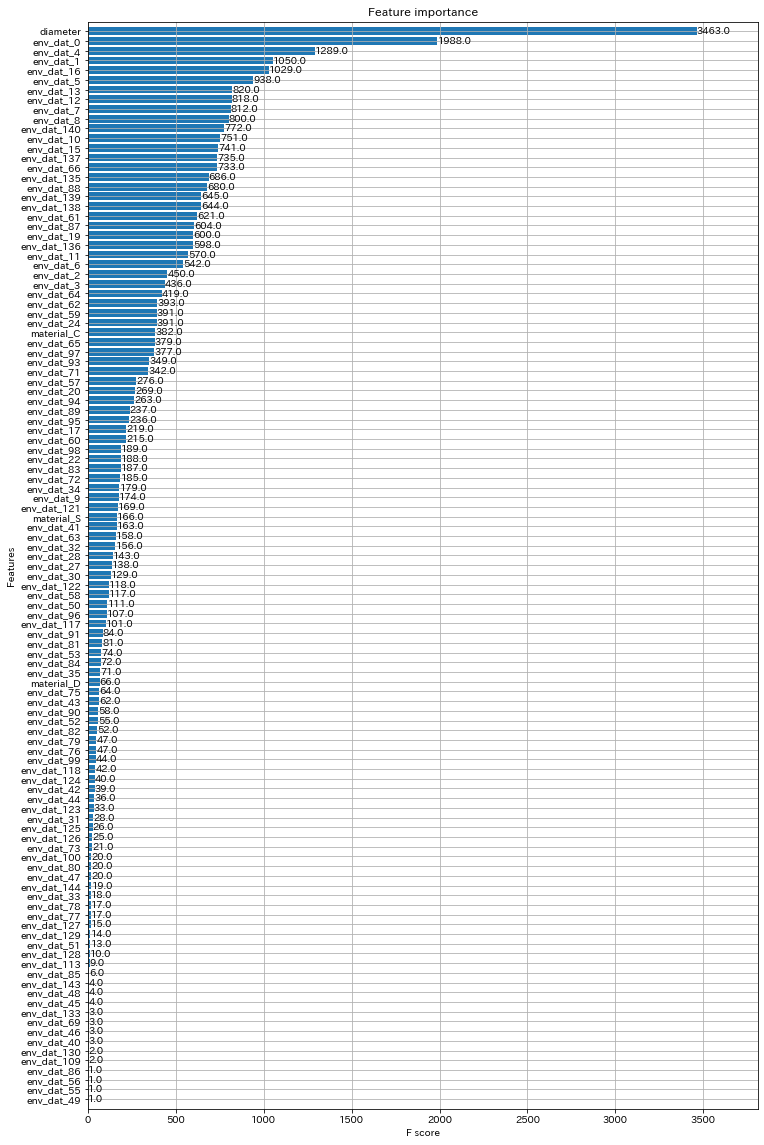

In [66]:
git, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(model, max_num_features=120, height=0.8, ax=ax)
plt.show()

In [67]:
scores = calculate_scores(y_test, y_pred_test)
display(scores)

,R2,MAE,MSE,RMSE
scores,0.50971,15.222475,390.30281,19.756083


In [70]:
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dvalid)

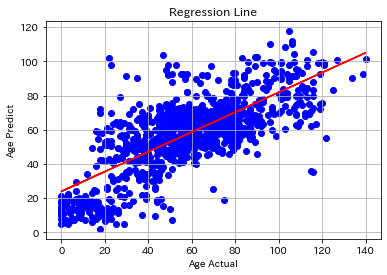

In [71]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

y_list_test = y_test.to_numpy()
lr.fit(y_list_test.reshape(-1, 1), y_pred_test)

plt.scatter(y_list_test, y_pred_test, color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(y_list_test, lr.predict(y_list_test.reshape(-1, 1)), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')
plt.xlabel('Age Actual')
plt.ylabel('Age Predict')
plt.grid()

plt.show()

In [72]:
dA = xgb.DMatrix(A)

In [73]:
pred = model.predict(dA)

In [74]:
A['age'] = pd.DataFrame(pred.tolist()).astype(int)
A['install_year'] = A_install_year
A['break_year'] = A['install_year'] + A['age']

### XGBoostを使用した際の2021年における故障率の算出

In [76]:
def prob_break(A):

    p_s = (len(A) - len(A[A['break_year'] <= 2020])) / len(A) 
    display(p_s)

    p_d = len(A[A['break_year'] == 2021]) / len(A)
    display (p_d)

    p_2021 = p_d / p_s

    result = pd.DataFrame({'確率Probability of pipe break in 2021': p_2021},
                        index = ['Result'])

    return result    


display(prob_break(A))

0.3784449002424016

0.010572440798060787

,確率Probability of pipe break in 2021
Result,0.027937


In [77]:
display(my_metric(A))

0.05771023680775689